In [61]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import time
import pickle as pk
import matplotlib.pyplot as plt
import json
from glob import glob
from utils import plot_results

# Definições iniciais

## Initializing Constants

In [62]:
# Opening JSON file
with open("control_dicts/constant_properties.json", "r") as openfile:
    # Reading from json file
    constant_properties = json.load(openfile)

Db = constant_properties["Db"]
Dn = constant_properties["Dn"]
phi = constant_properties["phi"]
cb = constant_properties["cb"]
lambd_nb = constant_properties["lambd_nb"]
mi_n = constant_properties["mi_n"]
lambd_bn = constant_properties["lambd_bn"]
y_n = constant_properties["y_n"]
Cn_max = constant_properties["Cn_max"]
X_nb = constant_properties["X_nb"]
central_ini_cond = constant_properties["central_ini_cond"]

# Opening JSON file
with open("control_dicts/mesh_properties.json", "r") as openfile:
    # Reading from json file
    mesh_properties = json.load(openfile)

h = mesh_properties["h"]
k = mesh_properties["k"]
x_dom = mesh_properties["x_dom"]
y_dom = mesh_properties["y_dom"]
t_dom = mesh_properties["t_dom"]

## Reading results file

In [63]:
def get_infection_site(struct_name):

    center_str = (struct_name).split("__")[-3].split("(")[-1].split(")")[0].split(",")

    center = (float(center_str[0]), float(center_str[1]))

    radius = float(struct_name.split("__")[-2].split("--")[-1].split(".pkl")[0])

    return center, radius


def read_files(path):
    file_list = sorted(glob(path + "/*"))

    speed_up_list = []
    Cl_list = []
    Cp_list = []

    for file in file_list:

        variable = lambda a: a.split("/")[-1].split("__")[0]

        if variable(file) == "Cl":
            Cl_list.append(file)

        elif variable(file) == "Cp":
            Cp_list.append(file)

        elif variable(file) == "speed_up":
            speed_up_list.append(file)

    return Cl_list, Cp_list, speed_up_list


def format_array(Cp_file, Cl_file):

    with open(Cp_file, "rb") as f:
        Cp = pk.load(f)

    with open(Cl_file, "rb") as f:
        Cl = pk.load(f)

    center, radius = get_infection_site(Cp_file)

    return Cp, Cl, center, radius

In [64]:
Cl_list, Cp_list, speed_up_list = read_files("fvm_sim")

Cp_fvm, Cl_fvm, center, radius = format_array(Cp_list[0], Cl_list[0])

## Formatting input parameters

In [65]:
def get_mesh_properties(
    x_dom,
    y_dom,
    t_dom,
    h,
    k,
    verbose=True,
):

    size_x = int(((x_dom[1] - x_dom[0]) / (h)))
    size_y = int(((y_dom[1] - y_dom[0]) / (h)))
    size_t = int(((t_dom[1] - t_dom[0]) / (k)) + 1)

    if verbose:
        print(
            "Steps in time = {:d}\nSteps in space_x = {:d}\nSteps in space_y = {:d}\n".format(
                size_t,
                size_x,
                size_y,
            )
        )

    return (size_x, size_y, size_t)

In [66]:
size_x, size_y, size_t = get_mesh_properties(x_dom, y_dom, t_dom, h, k)

Steps in time = 501
Steps in space_x = 20
Steps in space_y = 1



## Input verification

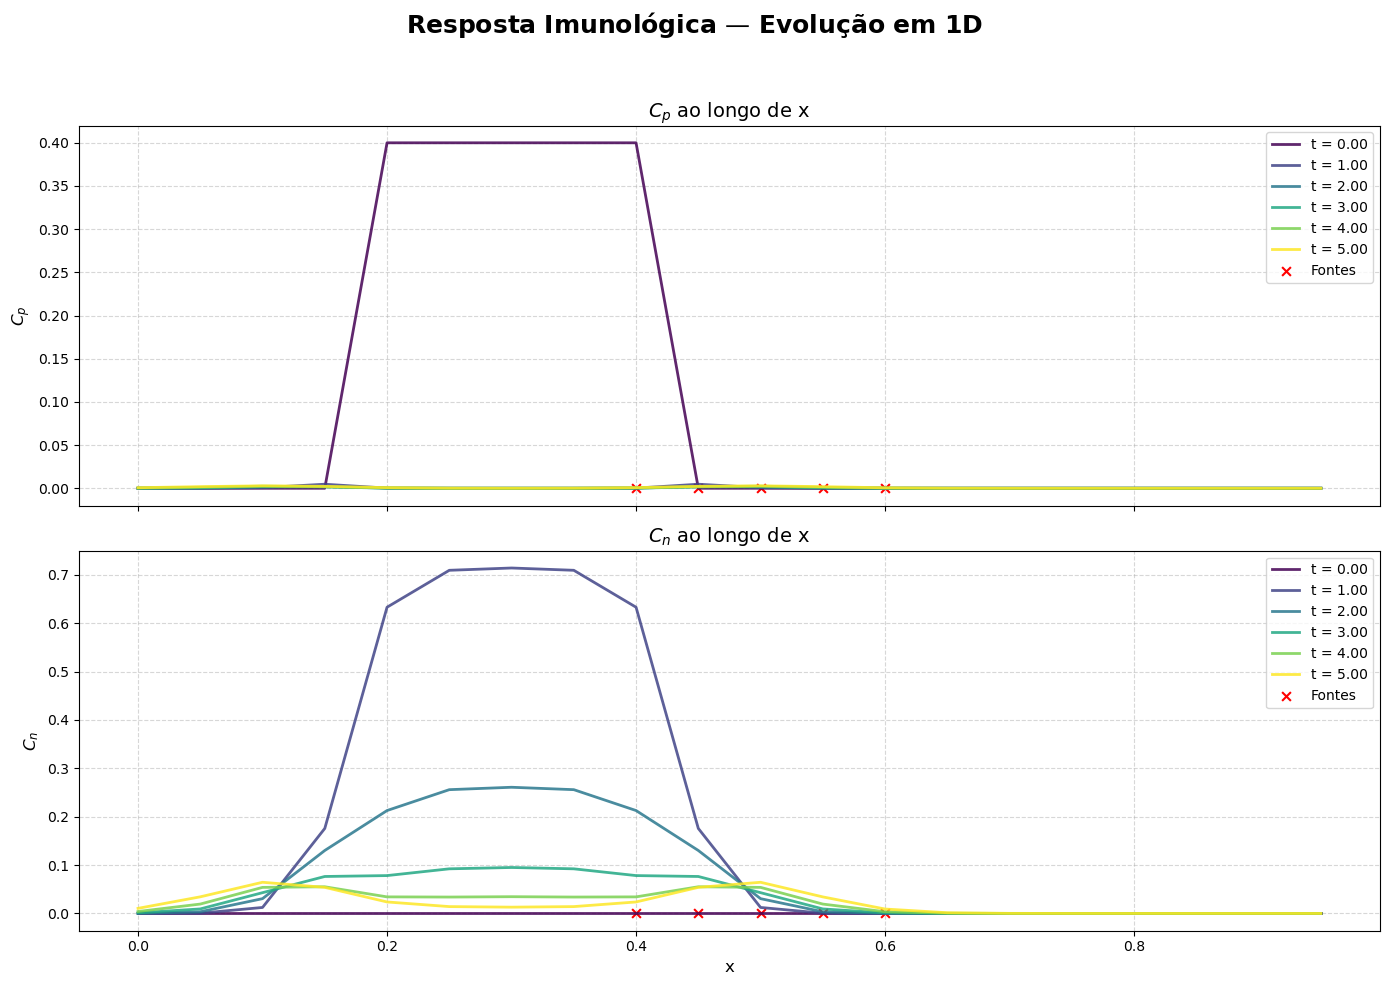

In [67]:
with open("source_points/lymph_vessels.pkl", "rb") as f:
    leu_source_points = pk.load(f)

plot_results(size_t,size_x,t_dom,x_dom,Cp_fvm,Cl_fvm,leu_source_points)

## Allocate GPU memmory

In [68]:
def under_sampling(n_samples, Cl, Cp):

    choosen_points = np.linspace(
        0, len(Cl) - 1, num=n_samples, endpoint=True, dtype=int
    )

    reduced_Cl = np.zeros((n_samples, Cl.shape[1], Cl.shape[2]))

    reduced_Cp = np.zeros((n_samples, Cp.shape[1], Cl.shape[2]))

    for i, idx in enumerate(choosen_points):

        reduced_Cl[i, :] = Cl[idx, :, :]

        reduced_Cp[i, :] = Cp[idx, :, :]

    return reduced_Cl, reduced_Cp, choosen_points

In [69]:
def create_input_mesh(t_dom, x_dom, size_t, size_x, n_samples=None):

    x_np = np.linspace(
        x_dom[0], x_dom[-1], num=size_x, endpoint=False, dtype=np.float32
    )

    if n_samples:

        reduced_Cl, reduced_Cp, choosen_points = under_sampling(
            n_samples, Cl_fvm, Cp_fvm
        )

        t_np = np.linspace(
            t_dom[0], t_dom[-1], num=size_t, endpoint=True, dtype=np.float32
        )[choosen_points]

        x_mesh, t_mesh = np.meshgrid(
            x_np,
            t_np,
        )

        return (
            reduced_Cl,
            reduced_Cp,
            t_mesh,
            x_mesh,
        )

    t_np = np.linspace(t_dom[0], t_dom[-1], num=size_t, endpoint=True, dtype=np.float32)

    x_mesh, t_mesh = np.meshgrid(
        x_np,
        t_np,
    )

    return (
        t_mesh,
        x_mesh,
    )

In [70]:
def allocates_training_mesh(
    t_dom,
    x_dom,
    size_t,
    size_x,
    center_x,
    initial_cond,
    radius,
    Cp_fvm,
    Cl_fvm,
    n_samples=None,
):

    (
        t_mesh,
        x_mesh,
    ) = create_input_mesh(t_dom, x_dom, size_t, size_x)

    if torch.cuda.is_available():
        device = torch.device("cuda")

    else:
        device = "cpu"

    print("device:", device)

    initial_tc = (
        torch.tensor(initial_cond, dtype=torch.float32)
        .reshape(-1, 1)
        .requires_grad_(True)
    )

    center_x_tc = (
        torch.tensor(center_x, dtype=torch.float32).reshape(-1, 1).requires_grad_(True)
    )

    radius_tc = (
        torch.tensor(radius, dtype=torch.float32).reshape(-1, 1).requires_grad_(True)
    )

    t_tc = torch.tensor(t_mesh, dtype=torch.float32).reshape(-1, 1).requires_grad_(True)

    x_tc = torch.tensor(x_mesh, dtype=torch.float32).reshape(-1, 1).requires_grad_(True)

    target = torch.tensor(
        np.array([Cl_fvm.flatten(), Cp_fvm.flatten()]).T,
        dtype=torch.float32,
    )

    if n_samples:

        (
            reduced_Cl,
            reduced_Cp,
            reduced_t_mesh,
            reduced_x_mesh,
        ) = create_input_mesh(t_dom, x_dom, size_t, size_x, n_samples)

        reduced_t_tc = (
            torch.tensor(reduced_t_mesh, dtype=torch.float32)
            .reshape(-1, 1)
            .requires_grad_(True)
        )

        reduced_x_tc = (
            torch.tensor(reduced_x_mesh, dtype=torch.float32)
            .reshape(-1, 1)
            .requires_grad_(True)
        )

        reduced_target = torch.tensor(
            np.array([reduced_Cl.flatten(), reduced_Cp.flatten()]).T,
            dtype=torch.float32,
        )

        return (
            initial_tc,
            center_x_tc,
            radius_tc,
            t_tc,
            x_tc,
            target,
            reduced_t_tc,
            reduced_x_tc,
            reduced_target,
            device,
        )

    else:
        return (
            initial_tc,
            center_x_tc,
            radius_tc,
            t_tc,
            x_tc,
            target,
            device,
        )

In [71]:
n_samples = 1
(
    initial_tc,
    center_x_tc,
    radius_tc,
    t_tc,
    x_tc,
    target,
    reduced_t_tc,
    reduced_x_tc,
    reduced_target,
    device,
) = allocates_training_mesh(
    t_dom,
    x_dom,
    size_t,
    size_x,
    center[0],
    central_ini_cond,
    radius,
    Cp_fvm,
    Cl_fvm,
    n_samples,
)

device: cuda


## Allocation validation

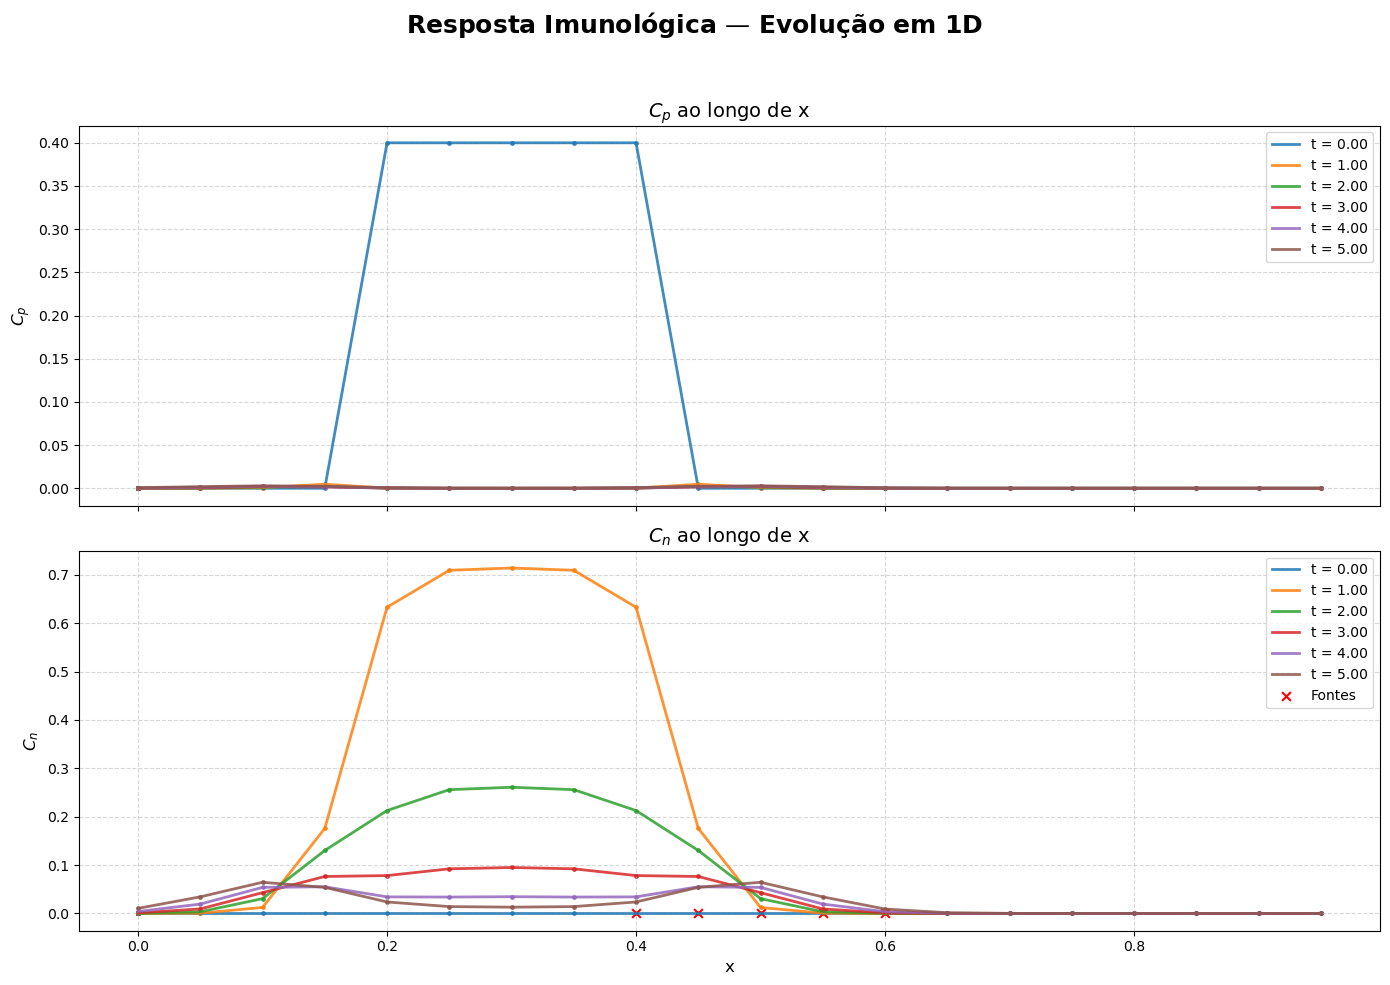

In [72]:
Cl_tc, Cp_tc = target.split(1, dim=1)

Cl = Cl_tc.cpu().detach().numpy().reshape(Cl_fvm.shape)
Cp = Cp_tc.cpu().detach().numpy().reshape(Cl_fvm.shape)

t_np = np.linspace(t_dom[0], t_dom[-1], num=size_t, endpoint=True, dtype=np.float32)
x_np = np.linspace(x_dom[0], x_dom[-1], num=size_x, endpoint=False, dtype=np.float32)

# t_np, x_np, Cp, Cl, source_index already defined
# source_index is assumed to be an array of x positions only (1D or Nx1)

time_plot = np.linspace(0, size_t - 1, num=6, endpoint=True, dtype=int)

fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

fig.suptitle(
    "$\\bf{Resposta\\ Imunológica}$ — Evolução em 1D", fontsize=18, weight="bold"
)

source_index = np.argwhere(leu_source_points[:, 0] == 1).ravel()


for i, time_inst in enumerate(time_plot):
    axes[0].plot(
        x_np,
        Cp[time_inst].squeeze(),
        label=f"t = {t_np[time_inst]:.2f}",
        linewidth=2,
        alpha=0.85,
    )

    time_ft = np.argwhere(t_tc.detach().numpy() == t_np[time_inst]).ravel()

    axes[0].scatter(
        x_tc[time_ft].detach().numpy(),
        Cp_tc[time_ft].detach().numpy(),
        s=6,
        alpha=0.85,
    )

axes[0].set_title("$C_p$ ao longo de x", fontsize=14)
axes[0].set_ylabel("$C_p$", fontsize=12)
axes[0].legend()
axes[0].grid(True, linestyle="--", alpha=0.5)

# Plot Cl
for i, time_inst in enumerate(time_plot):
    axes[1].plot(
        x_np,
        Cl[time_inst].squeeze(),
        label=f"t = {t_np[time_inst]:.2f}",
        linewidth=2,
        alpha=0.85,
    )

    time_ft = np.argwhere(t_tc.detach().numpy() == t_np[time_inst]).ravel()

    axes[1].scatter(
        x_tc[time_ft].detach().numpy(),
        Cl_tc[time_ft].detach().numpy(),
        s=6,
        alpha=0.85,
    )

axes[1].scatter(
    x_np[source_index],
    np.zeros((len(source_index))),
    color="red",
    label="Fontes",
    s=40,
    marker="x",
)

axes[1].set_title("$C_n$ ao longo de x", fontsize=14)
axes[1].set_xlabel("x", fontsize=12)
axes[1].set_ylabel("$C_n$", fontsize=12)
axes[1].legend()
axes[1].grid(True, linestyle="--", alpha=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Archtecture handling

In [73]:
activation_dict = {
    "Elu": nn.ELU,
    "LeakyReLU": nn.LeakyReLU,
    "Sigmoid": nn.Sigmoid,
    "Softplus": nn.Softplus,
    "Tanh": nn.Tanh,
    "Linear": nn.Linear,
    "ReLU": nn.ReLU,
    "RReLU": nn.RReLU,
    "SELU": nn.SELU,
    "CELU": nn.CELU,
    "GELU": nn.GELU,
    "SiLU": nn.SiLU,
    "GLU": nn.GLU,
}

In [74]:
def generate_model(arch_str):
    hidden_layers = arch_str.split("__")

    modules = []

    for params in hidden_layers:
        if len(params) != 0:
            activation, out_neurons = params.split("--")

            if len(modules) == 0:
                if activation == "Linear":
                    modules.append(
                        activation_dict[activation](2, int(out_neurons)).float()
                    )

                else:
                    modules.append(nn.Linear(2, int(out_neurons)).float())
                    modules.append(activation_dict[activation]().float())

            else:
                if activation == "Linear":
                    modules.append(
                        activation_dict[activation](
                            int(in_neurons), int(out_neurons)
                        ).float()
                    )

                else:
                    modules.append(nn.Linear(int(in_neurons), int(out_neurons)).float())
                    modules.append(activation_dict[activation]().float())

            in_neurons = out_neurons

    modules.append(nn.Linear(int(in_neurons), 2).float())

    return nn.Sequential(*modules)


def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

# PINN

## Normalization

## Training

In [75]:
def shuffle_data(t, x, target):

    # Create a list of indices matching the number of samples
    Data_num = np.arange(x.shape[0])

    # Shuffle the order of the indices
    np.random.shuffle(Data_num)

    # Return the input tensors reordered by the shuffled indices
    return (
        t[Data_num],
        x[Data_num],
        target[Data_num],
    )


def train_test_split(
    t,
    x,
    target,
    device,
    test_size=0.5,
    shuffle=True,
):
    with torch.no_grad():
        if shuffle:
            # Shuffle the dataset before splitting (optional)
            t, x, target = shuffle_data(t, x, target)

        if test_size < 1:
            # If test_size is a fraction (e.g., 0.2 for 20%)
            train_ratio = len(x) - int(len(x) * test_size)

            # Split each variable into train and test subsets
            t_train, t_test = t[:train_ratio], t[train_ratio:]
            x_train, x_test = x[:train_ratio], x[train_ratio:]
            target_train, target_test = target[:train_ratio], target[train_ratio:]

            # Move all tensors to the specified device (CPU or GPU)
            return (
                t_train,
                t_test,
                x_train,
                x_test,
                target_train,
                target_test,
            )

        elif test_size in range(1, len(x)):
            # If test_size is an integer (e.g., 100 samples for testing)
            t_train, t_test = t[test_size:], t[:test_size]
            x_train, x_test = x[test_size:], x[:test_size]
            target_train, target_test = target[test_size:], target[:test_size]

            # Move all tensors to the specified device (CPU or GPU)
            return (
                t_train,
                t_test,
                x_train,
                x_test,
                target_train,
                target_test,
            )


def generate_training_points(num_points, device):
    # Generate random (uniform) points in [0, 1) for time, x, and y
    t = torch.rand(num_points, 1, dtype=torch.float32) * 5

    x = torch.rand(num_points, 1, dtype=torch.float32)

    # Set requires_grad=True so we can compute PDE derivatives using autograd
    # Move each tensor to the specified device
    return (
        t.requires_grad_(True).to(device),
        x.requires_grad_(True).to(device),
    )


def generate_boundary_points(num_points, device):
    # Create a tensor for the x-coordinate with values [0.0, 1.0],
    # repeated (num_points // 2) times, each repetition has shape (2,).

    x_boundary = torch.tensor([0.0, 1], dtype=torch.float32).repeat(num_points // 2, 1)

    # If we do not swap, then n is the normal vector for a "left-right" boundary.
    n = torch.tensor([-1, 1], dtype=torch.float32).repeat(num_points // 2, 1)

    # Reshape x_boundary and y_boundary to have shape (num_points, 1),
    # mark them to require gradient, and move them to the given device (CPU or GPU).
    return (
        x_boundary.view(-1, 1).requires_grad_(True).to(device),
        # n is also set to require gradient and moved to device.
        n.view(-1, 1).requires_grad_(True).to(device),
    )


def initial_condition_points(n_samples,device):

    # Prepare a (num_points, 2) tensor for storing the initial conditions.
    # By default, it is filled with zeros for both columns (Cl, Cp).
    C_init = torch.zeros((n_samples, 2), dtype=torch.float32)

    # For all points inside the circle, assign initial_tc to the second column (here, the "pathogen" column).
    # We do this by multiplying the boolean mask with the desired initial value.
    # The .ravel() ensures consistent 1D shapes for broadcasting.
    C_init[0, :] = 1

    # Return the x, y coordinates and the initialized 2-column tensor (C_init).
    return C_init.to(device)


def boundary_condition(t_b, x_b, n, model):

    input_data = torch.cat([t_b, x_b], dim=1)

    Cp, Cl = model(input_data).tensor_split(2, dim=1)

    dCp_dx = torch.autograd.grad(
        Cp,
        x_b,
        grad_outputs=torch.ones_like(Cp),
        create_graph=True,
        retain_graph=True,
    )[0]

    dCl_dx = torch.autograd.grad(
        Cl,
        x_b,
        grad_outputs=torch.ones_like(Cl),
        create_graph=True,
        retain_graph=True,
    )[0]

    Cl_boundary = dCl_dx * n

    Cp_boundary = dCp_dx * n

    return torch.cat([Cl_boundary, Cp_boundary], dim=1)


def pde(
    model,
    t,
    x,
    phi,
    Db,
    Dn,
):

    Cl, Cp = model(torch.cat([t, x], dim=1)).tensor_split(2, dim=1)

    dCp_dx = torch.autograd.grad(
        Cp,
        x,
        grad_outputs=torch.ones_like(Cp),
        create_graph=True,
        retain_graph=True,
    )[0]

    dCp_dx_2 = torch.autograd.grad(
        dCp_dx,
        x,
        grad_outputs=torch.ones_like(dCp_dx),
        create_graph=True,
        retain_graph=True,
    )[0]

    dCp_dt = torch.autograd.grad(
        Cp,
        t,
        grad_outputs=torch.ones_like(Cp),
        create_graph=True,
        retain_graph=True,
    )[0]

    dCl_dx = torch.autograd.grad(
        Cl,
        x,
        grad_outputs=torch.ones_like(Cl),
        create_graph=True,
        retain_graph=True,
    )[0]

    dCl_dx_2 = torch.autograd.grad(
        dCl_dx,
        x,
        grad_outputs=torch.ones_like(dCl_dx),
        create_graph=True,
        retain_graph=True,
    )[0]

    dCl_dt = torch.autograd.grad(
        Cl,
        t,
        grad_outputs=torch.ones_like(Cl),
        create_graph=True,
        retain_graph=True,
    )[0]

    # Calculating Cp value

    Cp_eq = Db * dCp_dx_2 - dCp_dt * phi

    # Calculating Cl value

    Cl_eq = Dn * dCl_dx_2 - dCl_dt * phi

    return torch.cat([Cl_eq, Cp_eq], dim=1)

In [92]:
class train:
    def __init__(
        self,
        n_epochs,
        batch_size,
        decay_rate,
        model,
        device,
        target,
        t,
        x,
        center_x_tc,
        radius_tc,
        initial_tc,
        n_points,
        constant_properties,
        leu_source_points,
        validation=None,
        tolerance=None,
        patience=10,
        lr_rate=1e-3,
    ):
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.decay_rate = decay_rate
        self.model = model.to(device)
        self.device = device
        self.target = target
        self.t = t
        self.x = x
        self.leu_sc_tc = (
            torch.tensor(leu_source_points, dtype=torch.float32)
            .ravel()
            .requires_grad_(True)
            .to(device)
        )
        self.n_points = n_points
        self.constant_properties = constant_properties
        self.validation = validation
        self.tolerance = tolerance
        self.patience = patience
        self.lr_rate = lr_rate
        self.center_x_tc = center_x_tc.to(device)
        self.radius_tc = radius_tc.to(device)
        self.initial_tc = initial_tc.to(device)
        pass

    def loss_func(
        self,
    ):
        # Computing intial loss

        t_initial = torch.zeros_like(self.bt_t_train)

        C_init = initial_condition_points(
            len(self.bt_t_train),
            self.device,
        )

        mesh_ini = torch.cat(
            [t_initial, self.bt_x_train],
            dim=1,
        )

        C_initial_pred = self.model(mesh_ini)

        self.loss_initial = self.criterium(C_init, C_initial_pred)

        print("mesh_ini:", mesh_ini)
        print("C_initial_pred:", C_initial_pred)
        print("C_init:", C_init)

        # Computing pde loss

        # predicted_pde = pde(
        #     self.model,
        #     self.bt_t_train,
        #     self.bt_x_train,
        #     self.constant_properties["phi"],
        #     self.constant_properties["Db"],
        #     self.constant_properties["Dn"],
        # )

        # self.loss_pde = self.criterium(
        #     predicted_pde,
        #     torch.zeros_like(predicted_pde),
        # )

        # Computing boundary loss

        # x_bnd, n_bnd = generate_boundary_points(self.n_points, device)

        # predicted_boundary = boundary_condition(
        #     self.bt_t_train,
        #     x_bnd,
        #     n_bnd,
        #     self.model,
        # )

        # self.loss_boundary = self.criterium(
        #     predicted_boundary,
        #     torch.zeros_like(predicted_boundary),
        # )

        # # Computing data loss

        # mesh_data = torch.cat(
        #     [self.bt_t_train, self.bt_x_train],
        #     dim=1,
        # )

        # C_pred = self.model(mesh_data)

        # self.loss_data = self.criterium(self.bt_target_train, C_pred)

        self.loss = (
            10
            * self.loss_initial
            # + self.loss_pde
            # + self.loss_boundary
            # + 10 * self.loss_data
        )

        self.loss.backward()

        return self.loss

    def execute(
        self,
    ):
        self.criterium = nn.MSELoss()

        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr_rate)
        self.lr_scheduler = optim.lr_scheduler.ExponentialLR(
            optimizer=self.optimizer, gamma=self.decay_rate
        )

        if self.validation:
            (
                self.t_train,
                self.t_test,
                self.x_train,
                self.x_test,
                self.target_train,
                self.target_test,
            ) = train_test_split(
                self.t,  # normalized or raw
                self.x,
                self.target,
                self.device,
                test_size=self.validation,
            )

            self.test_input = (
                torch.cat([self.t_test, self.x_test], dim=1)
                .requires_grad_(True)
                .to(device)
            )

        else:
            self.target_train = self.target
            self.target_test = None
            self.t_train = self.t
            self.t_test = None
            self.x_train = self.x
            self.test_x = None
            self.x_test = None

        C_pde_loss_it = torch.zeros(self.n_epochs).to(device)
        C_data_loss_it = torch.zeros(self.n_epochs).to(device)
        C_boundary_loss_it = torch.zeros(self.n_epochs).to(device)
        C_initial_loss_it = torch.zeros(self.n_epochs).to(device)
        val_loss_it = torch.zeros(self.n_epochs).to(device)

        patience_count = 0
        val_loss = torch.tensor([1000])

        for epoch in range(self.n_epochs):
            for i in range(0, len(self.t_train), self.batch_size):

                self.bt_t_train = (
                    self.t_train[i : i + self.batch_size]
                    .requires_grad_(True)
                    .to(device)
                )
                self.bt_x_train = (
                    self.x_train[i : i + self.batch_size]
                    .requires_grad_(True)
                    .to(device)
                )
                self.bt_target_train = (
                    self.target_train[i : i + self.batch_size]
                    .requires_grad_(True)
                    .to(device)
                )

                self.optimizer.zero_grad()

                self.optimizer.step(self.loss_func)


                del self.bt_t_train
                del self.bt_x_train
                del self.bt_target_train

            self.lr_scheduler.step()

            # Computing validation loss

            if self.validation:
                with torch.no_grad():
                    val_old = val_loss
                    val_loss = self.criterium(
                        self.target_test.to(device), self.model(self.test_input)
                    )

            # C_pde_loss_it[epoch] = self.loss_pde.item()
            # C_boundary_loss_it[epoch] = self.loss_boundary.item()
            C_initial_loss_it[epoch] = self.loss_initial.item()
            # C_data_loss_it[epoch] = self.loss_data.item()
            val_loss_it[epoch] = val_loss.item() if self.validation else 0

            if ((epoch + 1) % 100) == 0 or (epoch == 0):
                print(
                    f"Finished epoch {epoch+1}, latest loss {self.loss}, validation loss {val_loss.item()}"
                    if self.validation
                    else f"Finished epoch {epoch+1}, latest loss {self.loss}"
                )

            if self.tolerance:

                if (
                    abs(val_old.item() - val_loss.item()) / val_old.item()
                    < self.tolerance
                ):
                    patience_count += 1

                else:
                    patience_count = 0

                if patience_count >= self.patience:

                    C_pde_loss_it = C_pde_loss_it[:epoch]
                    C_boundary_loss_it = C_boundary_loss_it[:epoch]
                    C_initial_loss_it = C_initial_loss_it[:epoch]
                    C_data_loss_it = C_data_loss_it[:epoch]
                    val_loss_it = val_loss_it[:epoch]

                    print("Early break!")

                    break

        return (
            self.model,
            C_pde_loss_it,
            C_boundary_loss_it,
            C_initial_loss_it,
            C_data_loss_it,
            val_loss_it,
        )

In [93]:
arch_str = "Elu--64__Tanh--64__ReLU--64__ReLU--64"

model = generate_model(arch_str).to(device).apply(init_weights)

print(model)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

Sequential(
  (0): Linear(in_features=2, out_features=64, bias=True)
  (1): ELU(alpha=1.0)
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): Tanh()
  (4): Linear(in_features=64, out_features=64, bias=True)
  (5): ReLU()
  (6): Linear(in_features=64, out_features=64, bias=True)
  (7): ReLU()
  (8): Linear(in_features=64, out_features=2, bias=True)
)
12802


In [94]:
decay_rate = 0.985
n_epochs = 600
batch_size = 4

trainer = train(
    n_epochs=n_epochs,
    batch_size=batch_size,
    decay_rate=decay_rate,
    model=model,
    device=device,
    target=reduced_target,
    x=reduced_x_tc,
    t=reduced_t_tc,
    center_x_tc=center_x_tc,
    radius_tc=radius_tc,
    initial_tc=initial_tc,
    n_points=batch_size,
    constant_properties=constant_properties,
    leu_source_points=leu_source_points,
    validation=0.1,
    tolerance=0.001,
    patience=60,
    lr_rate=1e-4,
)

In [95]:
torch.set_printoptions(threshold=10_000)
(
    model,
    C_pde_loss_it,
    C_boundary_loss_it,
    C_initial_loss_it,
    C_data_loss_it,
    val_loss_it,
) = trainer.execute()



mesh_ini: tensor([[0.0000, 0.5500],
        [0.0000, 0.8500],
        [0.0000, 0.9000],
        [0.0000, 0.2000]], device='cuda:0', grad_fn=<CatBackward0>)
C_initial_pred: tensor([[0.0653, 0.0592],
        [0.0972, 0.0867],
        [0.1022, 0.0909],
        [0.0245, 0.0228]], device='cuda:0', grad_fn=<AddmmBackward0>)
C_init: tensor([[1., 1.],
        [0., 0.],
        [0., 0.],
        [0., 0.]], device='cuda:0')
mesh_ini: tensor([[0.0000, 0.2500],
        [0.0000, 0.3500],
        [0.0000, 0.9500],
        [0.0000, 0.4000]], device='cuda:0', grad_fn=<CatBackward0>)
C_initial_pred: tensor([[0.0336, 0.0319],
        [0.0461, 0.0435],
        [0.1151, 0.1040],
        [0.0523, 0.0491]], device='cuda:0', grad_fn=<AddmmBackward0>)
C_init: tensor([[1., 1.],
        [0., 0.],
        [0., 0.],
        [0., 0.]], device='cuda:0')
mesh_ini: tensor([[0.0000, 0.4500],
        [0.0000, 0.6500],
        [0.0000, 0.1000],
        [0.0000, 0.1500]], device='cuda:0', grad_fn=<CatBackward0>)
C_initia

## Validation

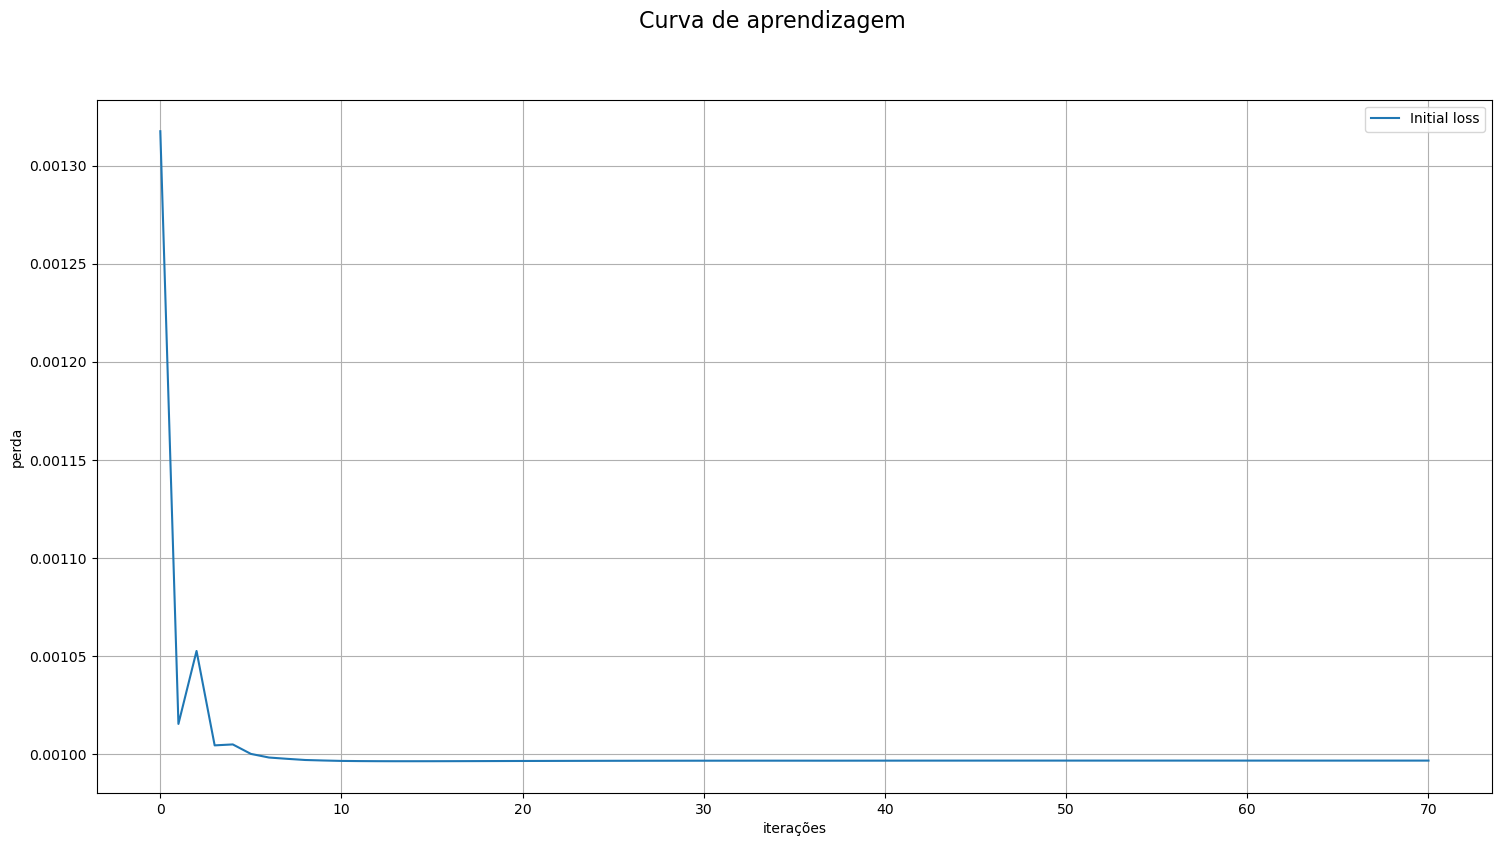

In [31]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[18, 9])

fig.suptitle("Curva de aprendizagem", fontsize=16)

# Plotango 3D
ax = fig.add_subplot(1, 1, 1)

ax.set_xlabel("iterações")
ax.set_ylabel("perda")
# ax.plot(
#     range(len(C_pde_loss_it.cpu().numpy())),
#     C_pde_loss_it.cpu().numpy(),
#     label="PDE loss",
# )

# ax.plot(
#     range(len(C_boundary_loss_it.cpu().numpy())),
#     C_boundary_loss_it.cpu().numpy(),
#     label="Boundary loss",
# )

# ax.plot(
#     range(len(val_loss_it.cpu().numpy())),
#     val_loss_it.cpu().numpy(),
#     label="Validation loss",
# )

# ax.plot(
#     range(len(C_data_loss_it.cpu().numpy())),
#     C_data_loss_it.cpu().numpy(),
#     label="Data loss",
# )

ax.plot(
    range(len(C_initial_loss_it.cpu().numpy())),
    C_initial_loss_it.cpu().numpy(),
    label="Initial loss",
)
# ax.set_yscale("log")
ax.grid()
ax.legend()

plt.show()

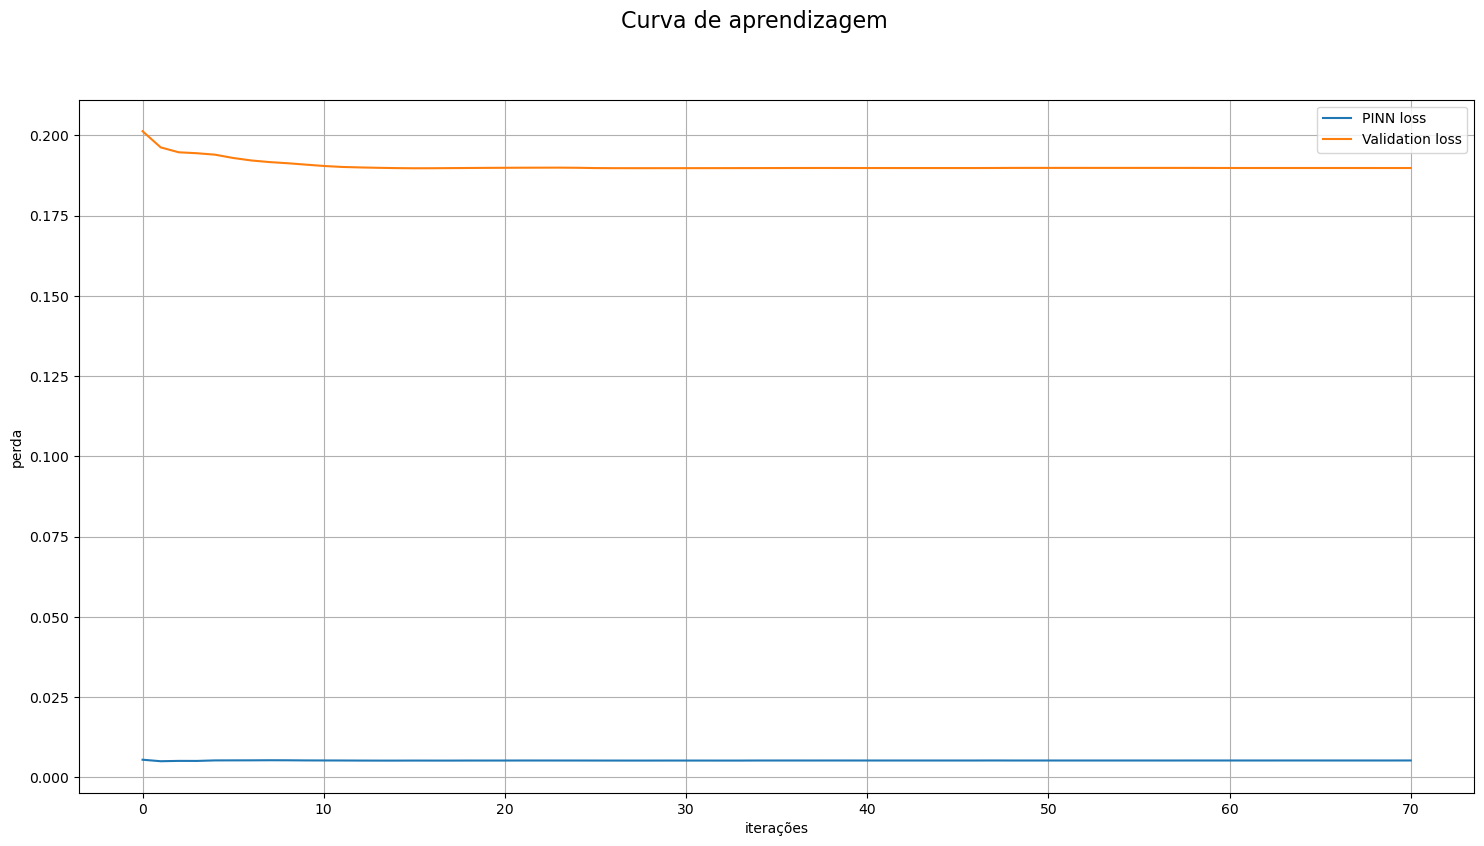

In [32]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[18, 9])

fig.suptitle("Curva de aprendizagem", fontsize=16)

# Plotango 3D
ax = fig.add_subplot(1, 1, 1)

ax.set_xlabel("iterações")
ax.set_ylabel("perda")

ax.plot(
    range(len(C_data_loss_it.cpu().numpy())),
    C_initial_loss_it.cpu().numpy()
    + C_pde_loss_it.cpu().numpy()
    + C_boundary_loss_it.cpu().numpy(),
    # + C_data_loss_it.cpu().numpy(),
    label="PINN loss",
)
ax.plot(
    range(len(val_loss_it.cpu().numpy())),
    val_loss_it.cpu().numpy(),
    label="Validation loss",
)
# ax.set_yscale("log")
ax.grid()
ax.legend()

plt.show()

In [33]:
mesh = torch.cat([t_tc, x_tc], dim=1).to(device)

with torch.no_grad():
    pred_pinn_dev = model(mesh)

pred_pinn = pred_pinn_dev.cpu().detach().numpy()

In [34]:
Cl_pinn_device, Cp_pinn_device = pred_pinn_dev.split(1, dim=1)

Cl_pinn_np = Cl_pinn_device.cpu().detach().numpy().reshape(Cl_fvm.shape)
Cp_pinn_np = Cp_pinn_device.cpu().detach().numpy().reshape(Cl_fvm.shape)

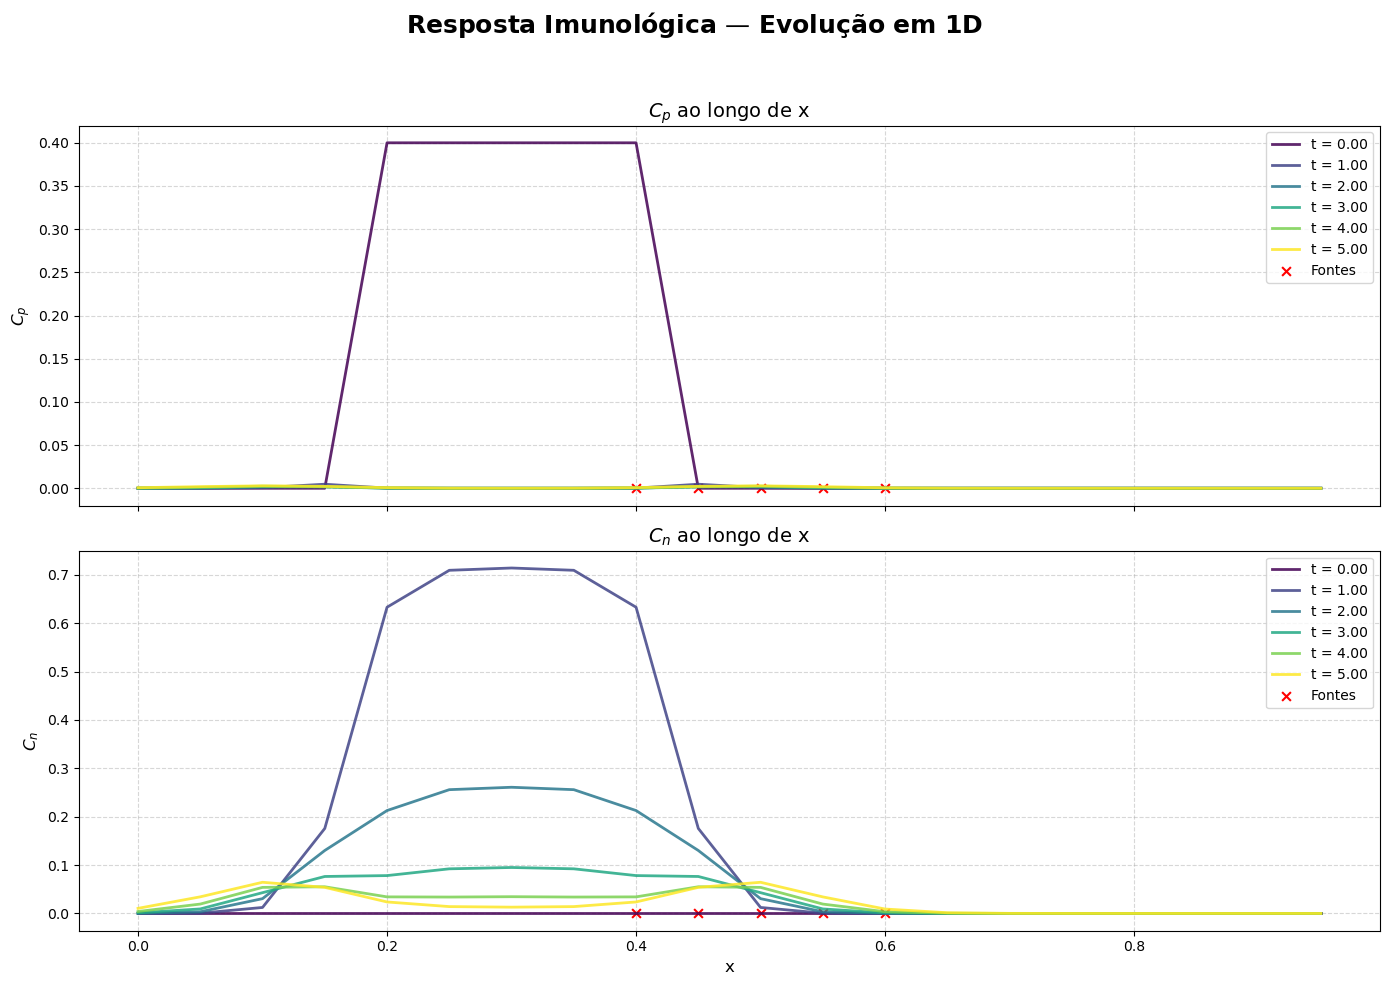

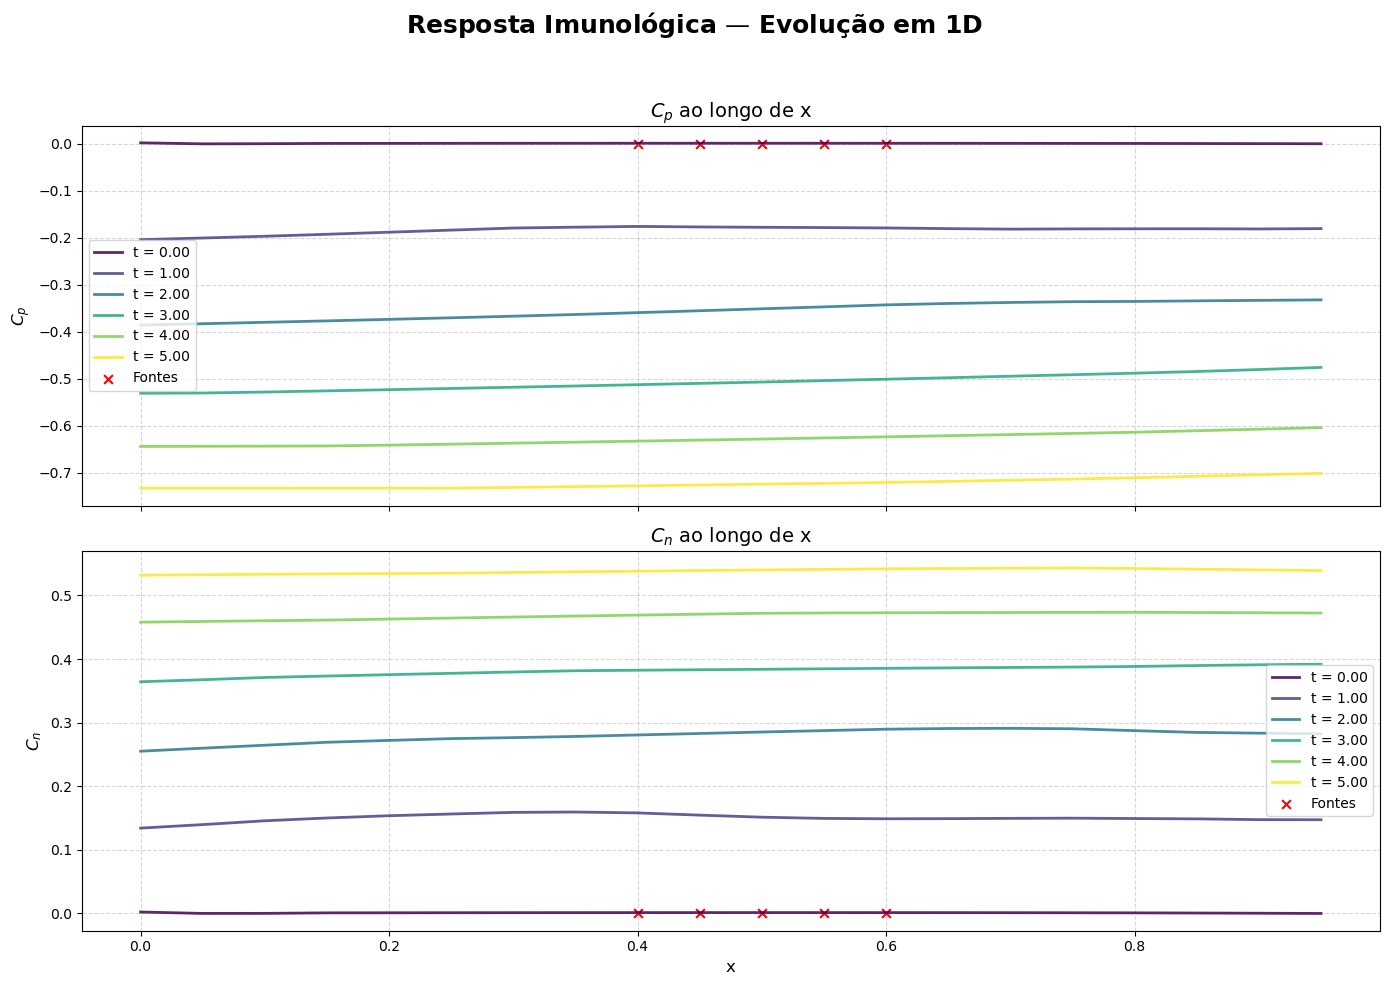

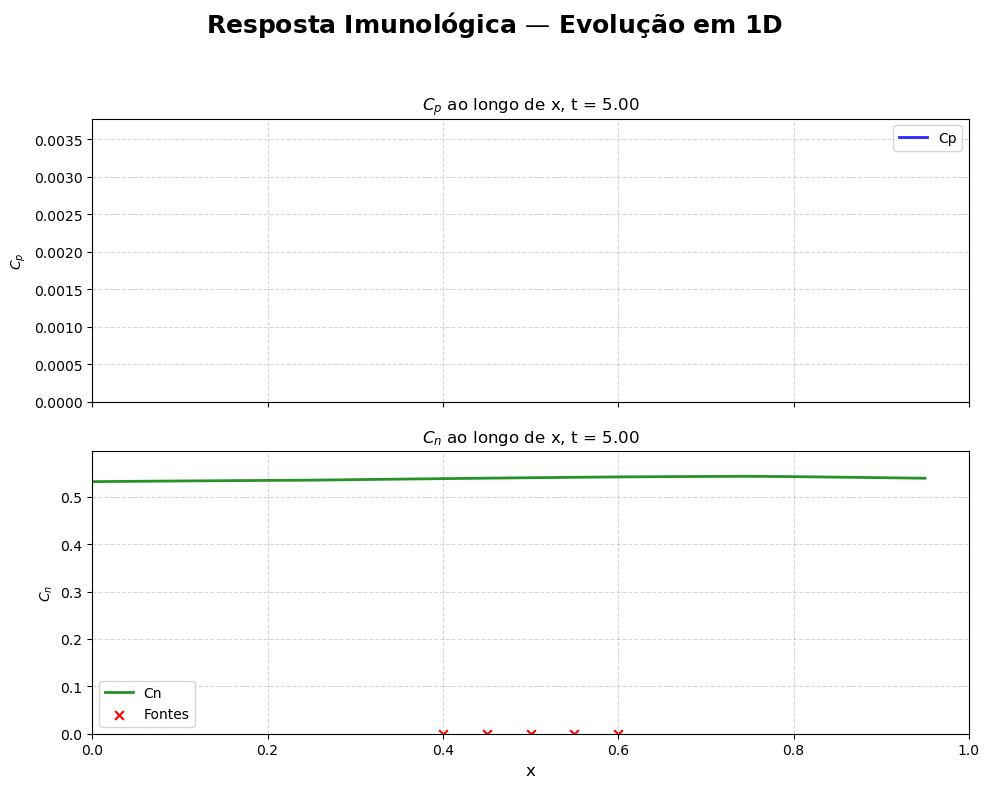

In [35]:
from fvm_animation import animate_1D_evolution

plot_results(size_t,size_x,t_dom,x_dom,Cp_fvm,Cl_fvm,leu_source_points)

plot_results(size_t,size_x,t_dom,x_dom,Cp_pinn_np,Cl_pinn_np,leu_source_points)

animate_1D_evolution(
    size_t,
    size_x,
    t_dom,
    x_dom,
    Cp_pinn_np,Cl_pinn_np,
    leu_source_points,
    (size_t - 1) // 100,
    150,
    name="evolucao_1D__",
)

## Saving model weights and biases

In [94]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
0.weight 	 torch.Size([8, 2])
0.bias 	 torch.Size([8])
2.weight 	 torch.Size([32, 8])
2.bias 	 torch.Size([32])
4.weight 	 torch.Size([8, 32])
4.bias 	 torch.Size([8])
6.weight 	 torch.Size([32, 8])
6.bias 	 torch.Size([32])
8.weight 	 torch.Size([2, 32])
8.bias 	 torch.Size([2])


In [95]:
import os

pinn_file = "epochs_{}__batch_{}__arch_".format(n_epochs, batch_size) + arch_str

cwd = os.getcwd()

torch.save(model.state_dict(), cwd + "/nn_parameters/" + pinn_file + ".pt")

del model
del trainer

# Training setup

In [96]:
import torch
import pickle as pk
import argparse
import os
import json
from pinn import *

# Opening JSON file
with open("control_dicts/constant_properties.json", "r") as openfile:
    # Reading from json file
    constant_properties = json.load(openfile)

Db = constant_properties["Db"]
Dn = constant_properties["Dn"]
phi = constant_properties["phi"]
cb = constant_properties["cb"]
lambd_nb = constant_properties["lambd_nb"]
mi_n = constant_properties["mi_n"]
lambd_bn = constant_properties["lambd_bn"]
y_n = constant_properties["y_n"]
Cn_max = constant_properties["Cn_max"]
X_nb = constant_properties["X_nb"]
central_ini_cond = constant_properties["central_ini_cond"]


# Opening JSON file
with open("control_dicts/mesh_properties.json", "r") as openfile:
    # Reading from json file
    mesh_properties = json.load(openfile)

h = mesh_properties["h"]
k = mesh_properties["k"]
x_dom = mesh_properties["x_dom"]
y_dom = mesh_properties["y_dom"]
t_dom = mesh_properties["t_dom"]


Cl_list, Cp_list, speed_up_list = read_files("fvm_sim")

Cp_fvm, Cl_fvm, center, radius = format_array(Cp_list[0], Cl_list[0])


size_x, size_y, size_t = get_mesh_properties(x_dom, y_dom, t_dom, h, k)


(
    initial_tc,
    center_x_tc,
    center_y_tc,
    radius_tc,
    t_tc,
    x_tc,
    y_tc,
    target,
    reduced_t_tc,
    reduced_x_tc,
    reduced_y_tc,
    reduced_target,
    device,
) = allocates_training_mesh(
    t_dom,
    x_dom,
    y_dom,
    size_t,
    size_x,
    size_y,
    center[0],
    center[1],
    central_ini_cond,
    radius,
    Cp_fvm,
    Cl_fvm,
    3000,
)


arch_str = "Tanh--32__Tanh--32__Tanh--32__GELU--32"

model = generate_model(arch_str).to(device).apply(init_weights)

print(model)

decay_rate = 0.9985
n_epochs = 300
val = 0.2
batch_size = int(len(t_tc) * (1 - val) / 10)
lr_rate = 6e-4

trainer = train(
    n_epochs=n_epochs,
    batch_size=batch_size,
    decay_rate=decay_rate,
    model=model,
    initial_tc=initial_tc,
    center_x_tc=center_x_tc,
    center_y_tc=center_y_tc,
    radius_tc=radius_tc,
    t_tc=reduced_t_tc,
    x_tc=reduced_x_tc,
    y_tc=reduced_y_tc,
    target=reduced_target,
    device=device,
    n_points=batch_size,
    constant_properties=constant_properties,
    validation=val,
    tolerance=0.02,
    patience=20,
    normalize=True,
    lr_rate=lr_rate,
)


(
    model,
    C_pde_loss_it,
    C_boundary_loss_it,
    C_initial_loss_it,
    C_data_loss_it,
    val_loss_it,
) = trainer.execute()


# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

pinn_file = (
    "decay_rates_{:.4}__lr_rates_{:.4}__arch_".format(decay_rate, lr_rate) + arch_str
)

cwd = os.getcwd()

torch.save(model.state_dict(), cwd + "/nn_parameters/" + pinn_file + ".pt")

with open("learning_curves/C_pde_loss_it_" + pinn_file + ".pkl", "wb") as openfile:
    # Reading from json file
    pk.dump(C_pde_loss_it.cpu().numpy(), openfile)

with open("learning_curves/C_boundary_loss_it_" + pinn_file + ".pkl", "wb") as openfile:
    # Reading from json file
    pk.dump(C_boundary_loss_it.cpu().numpy(), openfile)


with open("learning_curves/C_initial_loss_it_" + pinn_file + ".pkl", "wb") as openfile:
    # Reading from json file
    pk.dump(C_initial_loss_it.cpu().numpy(), openfile)


with open("learning_curves/C_data_loss_it_" + pinn_file + ".pkl", "wb") as openfile:
    # Reading from json file
    pk.dump(C_data_loss_it.cpu().numpy(), openfile)


with open("learning_curves/val_loss_it_" + pinn_file + ".pkl", "wb") as openfile:
    # Reading from json file
    pk.dump(val_loss_it.cpu().numpy(), openfile)

del model
del trainer

Steps in time = 501
Steps in space_x = 20
Steps in space_y = 1

device: cuda
Sequential(
  (0): Linear(in_features=3, out_features=32, bias=True)
  (1): Tanh()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): Tanh()
  (4): Linear(in_features=32, out_features=32, bias=True)
  (5): Tanh()
  (6): Linear(in_features=32, out_features=32, bias=True)
  (7): GELU(approximate='none')
  (8): Linear(in_features=32, out_features=2, bias=True)
)


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 801 but got size 800 for tensor number 2 in the list.

# Evaluation setup

In [1]:
from glob import glob
import time
import pickle as pk
import os
import json
from pinn import *

In [2]:
def load_model(file_name, device):
    cwd = os.getcwd()

    arch_str = (
        ("__")
        .join(file_name.split("/")[-1].split(".pt")[0].split("__")[2:])
        .split("arch_")[-1]
    )

    model = generate_model(arch_str).to(device)

    model.load_state_dict(
        torch.load(cwd + "/" + file_name, weights_only=True, map_location=device)
    )

    print(model.eval())

    return model


def read_speed_ups(speed_up_list):
    speed_up_obj = {}
    for i, file in enumerate(speed_up_list):
        with open(file, "rb") as f:
            speed_up_obj[i] = pk.load(f)

    return speed_up_obj

In [3]:
# Opening JSON file
with open("control_dicts/constant_properties.json", "r") as openfile:
    # Reading from json file
    constant_properties = json.load(openfile)

Db = constant_properties["Db"]
Dn = constant_properties["Dn"]
phi = constant_properties["phi"]
cb = constant_properties["cb"]
lambd_nb = constant_properties["lambd_nb"]
mi_n = constant_properties["mi_n"]
lambd_bn = constant_properties["lambd_bn"]
y_n = constant_properties["y_n"]
Cn_max = constant_properties["Cn_max"]
X_nb = constant_properties["X_nb"]
central_ini_cond = constant_properties["central_ini_cond"]


# Opening JSON file
with open("control_dicts/mesh_properties.json", "r") as openfile:
    # Reading from json file
    mesh_properties = json.load(openfile)

h = mesh_properties["h"]
k = mesh_properties["k"]
x_dom = mesh_properties["x_dom"]
y_dom = mesh_properties["y_dom"]
t_dom = mesh_properties["t_dom"]


Cl_list, Cp_list, speed_up_list = read_files("fvm_sim")

Cp_fvm, Cl_fvm, center, radius = format_array(Cp_list[0], Cl_list[0])


size_x, size_y, size_t = get_mesh_properties(x_dom, y_dom, t_dom, h, k)


(
    initial_tc,
    center_x_tc,
    center_y_tc,
    radius_tc,
    t_tc,
    x_tc,
    y_tc,
    target,
    reduced_t_tc,
    reduced_x_tc,
    reduced_y_tc,
    reduced_target,
    device,
) = allocates_training_mesh(
    t_dom,
    x_dom,
    y_dom,
    size_t,
    size_x,
    size_y,
    center[0],
    center[1],
    central_ini_cond,
    radius,
    Cp_fvm,
    Cl_fvm,
    3000,
)

Steps in time = 10001
Steps in space_x = 20
Steps in space_y = 20

device: cuda


In [40]:
nn_list = glob("nn_parameters/*")
run_list = list(
    map(
        lambda file: file.split("pinn_sim/")[-1]
        .split(".pkl")[0]
        .split("prediction_")[-1],
        glob("pinn_sim/*"),
    )
)

total = len(nn_list)

target = target.cpu().detach()

t_scaler = Scaler()
x_scaler = Scaler()
y_scaler = Scaler()
target_scaler = Scaler()

t_scaler.fit(t_tc)
x_scaler.fit(x_tc)
y_scaler.fit(y_tc)
target_scaler.fit(target)

norm_t_tc = t_scaler.normalize(t_tc)
norm_x_tc = x_scaler.normalize(x_tc)
norm_y_tc = y_scaler.normalize(y_tc)
norm_target = target_scaler.normalize(target)

for nn_num, nn_file in enumerate(nn_list[0:3]):

    if nn_file.split(".")[-1] == "pt":

        pinn_file = nn_file.split("nn_parameters/")[-1].split(".pt")[0]

        print(f"\n{nn_num+1} of {total}")

        print("=" * 20)

        print("PINN:", pinn_file)

        if pinn_file in run_list:
            print("Already evaluated")

        else:
            model = load_model(nn_file, device)

            speed_up_obj = read_speed_ups(speed_up_list)

            output = {
                "mean_speed_up": [],
                "std_speed_up": 0,
                "mean_speed_comp_up": [],
                "std_speed_comp_up": 0,
                "mean_speed_up_pinn": [],
                "std_speed_up_pinn": 0,
                "mean_serial_time": [],
                "std_serial_time": 0,
                "mean_cuda_time": [],
                "std_cuda_time": 0,
                "mean_pinn_time": [],
                "std_pinn_time": 0,
            }

            prediction = {}

            error = np.zeros((len(speed_up_obj.keys()), len(target)))

            for i in speed_up_obj.keys():

                start = time.time()

                mesh = torch.cat([norm_t_tc, norm_x_tc, norm_y_tc], dim=1).to(device)

                with torch.no_grad():
                    pred_pinn_dev = model(mesh)

                pred_pinn = pred_pinn_dev.cpu().detach().numpy()

                end = time.time()

                pinn_time = end - start

                speed_up_obj[i]["pinn_time"] = pinn_time

                speed_up_obj[i]["speed_up_pinn"] = (
                    speed_up_obj[i]["serial_time"] / pinn_time
                )

                output["mean_speed_up"].append(speed_up_obj[i]["speed_up"])

                output["mean_speed_comp_up"].append(speed_up_obj[i]["speed_comp_up"])

                output["mean_speed_up_pinn"].append(speed_up_obj[i]["speed_up_pinn"])

                output["mean_serial_time"].append(speed_up_obj[i]["serial_time"])

                output["mean_cuda_time"].append(speed_up_obj[i]["cuda_time"])

                output["mean_pinn_time"].append(speed_up_obj[i]["pinn_time"])

                aux = ((pred_pinn - norm_target.cpu().detach().numpy()) ** 2) ** 0.5

                error[i] = aux[:, 0] + aux[:, 1]

            output["std_speed_up"] = np.std(output["mean_speed_up"])
            output["std_speed_comp_up"] = np.std(output["mean_speed_comp_up"])
            output["std_speed_up_pinn"] = np.std(output["mean_speed_up_pinn"])
            output["std_serial_time"] = np.std(output["mean_serial_time"])
            output["std_cuda_time"] = np.std(output["mean_cuda_time"])
            output["std_pinn_time"] = np.std(output["mean_pinn_time"])

            output["mean_speed_up"] = np.mean(output["mean_speed_up"])
            output["mean_speed_comp_up"] = np.mean(output["mean_speed_comp_up"])
            output["mean_speed_up_pinn"] = np.mean(output["mean_speed_up_pinn"])
            output["mean_serial_time"] = np.mean(output["mean_serial_time"])
            output["mean_cuda_time"] = np.mean(output["mean_cuda_time"])
            output["mean_pinn_time"] = np.mean(output["mean_pinn_time"])

            rmse = np.mean(error.flatten())

            max_ae = np.max(error.flatten())

            prediction["pred_pinn"] = pred_pinn
            prediction["target"] = norm_target.cpu().detach().numpy()

            print("Erro absoluto médio", rmse)
            print("Erro absoluto máximo", max_ae)
            print(
                "Speed Up: {} +/-{}".format(
                    output["mean_speed_up"], output["std_speed_up"]
                )
            )
            print(
                "Compilation Speed Up: {} +/-{}".format(
                    output["mean_speed_comp_up"], output["std_speed_comp_up"]
                )
            )
            print(
                "PINN Speed Up: {} +/-{}".format(
                    output["mean_speed_up_pinn"], output["std_speed_up_pinn"]
                )
            )

            with open("pinn_sim/output_" + pinn_file + ".pkl", "wb") as openfile:
                # Reading from json file
                pk.dump(output, openfile)

            with open("pinn_sim/prediction_" + pinn_file + ".pkl", "wb") as openfile:
                # Reading from json file
                pk.dump(prediction, openfile)


1 of 23289
PINN: decay_rates_0.95__lr_rates_0.0001__arch_Tanh--16__Elu--8__Sigmoid--16__
Already evaluated

2 of 23289
PINN: decay_rates_0.9745__lr_rates_0.001__arch_Elu--32__Elu--8__Elu--16__
Already evaluated

3 of 23289
PINN: decay_rates_0.95__lr_rates_0.001__arch_Sigmoid--16__ReLU--32__SiLU--16__
Already evaluated


# Printing simulations

In [31]:
import matplotlib.pyplot as plt

with open("pinn_sim/prediction_" + pinn_file + ".pkl", "rb") as openfile:
    # Reading from json file
    prediction = pk.load(openfile)

In [32]:
pred_pinn = prediction["pred_pinn"]
target = prediction["target"]

In [34]:
Cl_pinn_device, Cp_pinn_device = np.split(pred_pinn, 2, axis=1)

Cl_pinn_np = Cl_pinn_device.reshape(Cp_fvm.shape)

Cp_pinn_np = Cp_pinn_device.reshape(Cp_fvm.shape)

Cl_target_dev, Cp_target_dev = np.split(target, 2, axis=1)

Cl_target_np = Cl_target_dev.reshape(Cp_fvm.shape)

Cp_target_np = Cp_target_dev.reshape(Cp_fvm.shape)

In [35]:
Cl_target_np.shape

(10001, 20, 20)

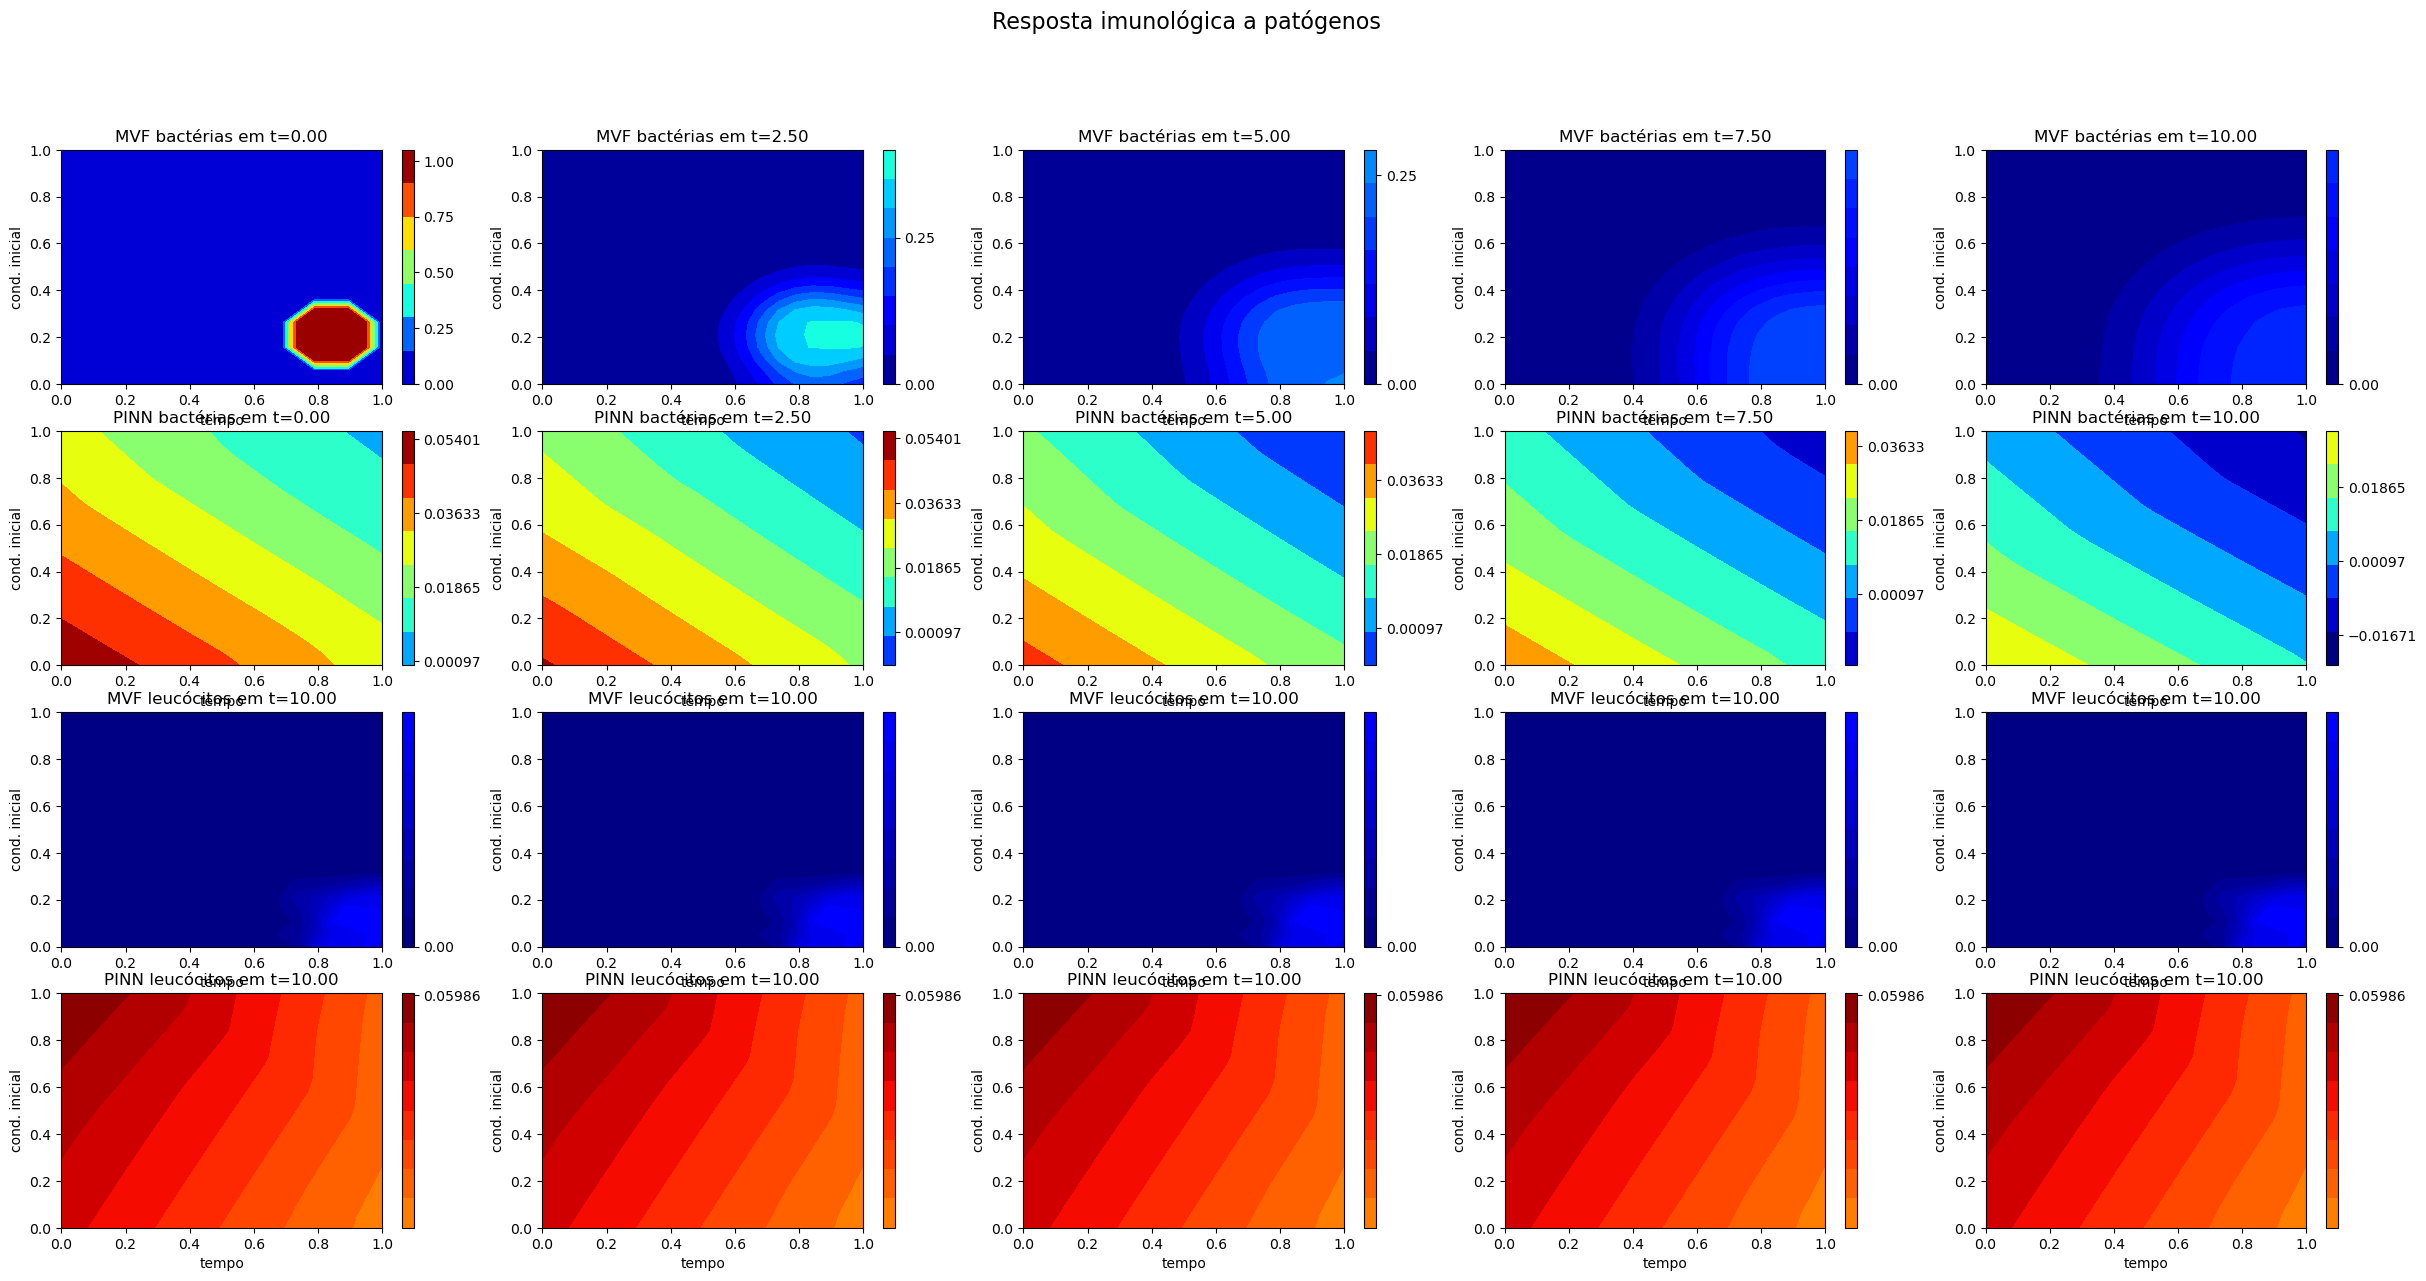

In [ ]:
t = np.linspace(t_dom[0], t_dom[-1], num=size_t, endpoint=True, dtype=np.float32)
x = np.linspace(x_dom[0], x_dom[-1], num=size_x, endpoint=True, dtype=np.float32)
y = np.linspace(y_dom[0], y_dom[-1], num=size_y, endpoint=True, dtype=np.float32)

X, Y = np.meshgrid(x, y)

time_plot = np.linspace(0, len(t) - 1, num=5, endpoint=True, dtype=int)

fig = plt.figure(figsize=[6 * len(time_plot), 14])

fig.suptitle("Resposta imunológica a patógenos", fontsize=16)

for i, it in enumerate(time_plot):
    # Plotango 3D
    ax = fig.add_subplot(4, len(time_plot), i + 1)

    vmin = np.min(Cp_target_np)
    vmax = np.max(Cp_target_np)

    contour = ax.contourf(
        X,
        Y,
        Cp_target_np[it],
        cmap="jet",
        vmin=vmin,
        vmax=vmax,
    )

    ax.set_title("MVF bactérias em t={:.2f}".format(t[it]))
    ax.set_xlabel("tempo")
    ax.set_ylabel("cond. inicial")
    colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

for i, time_inst in enumerate(time_plot):
    # Plotango 3D
    ax = fig.add_subplot(4, len(time_plot), i + len(time_plot) + 1)

    vmin = np.min(Cp_pinn_np)
    vmax = np.max(Cp_pinn_np)

    contour = ax.contourf(
        X,
        Y,
        Cp_pinn_np[time_inst],
        cmap="jet",
        vmin=vmin,
        vmax=vmax,
    )

    ax.set_title("PINN bactérias em t={:.2f}".format(t[time_inst]))
    ax.set_xlabel("tempo")
    ax.set_ylabel("cond. inicial")
    colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

for i, time_inst in enumerate(time_plot):
    # Plotango 3D
    ax = fig.add_subplot(4, len(time_plot), i + len(time_plot) * 2 + 1)

    vmin = np.min(Cl_target_np)
    vmax = np.max(Cl_target_np)

    contour = ax.contourf(
        X,
        Y,
        Cl_target_np[it],
        cmap="jet",
        vmin=vmin,
        vmax=vmax,
    )

    ax.set_title("MVF leucócitos em t={:.2f}".format(t[it]))
    ax.set_xlabel("tempo")
    ax.set_ylabel("cond. inicial")
    colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))


for i, it in enumerate(time_plot):
    # Plotango 3D
    ax = fig.add_subplot(4, len(time_plot), i + len(time_plot) * 3 + 1)

    vmin = np.min(Cl_pinn_np)
    vmax = np.max(Cl_pinn_np)

    contour = ax.contourf(
        X,
        Y,
        Cl_pinn_np[time_inst],
        cmap="jet",
        vmin=vmin,
        vmax=vmax,
    )

    ax.set_title("PINN leucócitos em t={:.2f}".format(t[time_inst]))
    ax.set_xlabel("tempo")
    ax.set_ylabel("cond. inicial")
    colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

plt.show()

In [21]:
from glob import glob

list_nn_parameters = glob("nn_parameters/*")

list_learning_curves = glob("learning_curves/*")

list_pinn_sim = glob("pinn_sim/*")